<a href="https://colab.research.google.com/github/mitsouma/IOT_Anomalies_Detection_System_Based_on_Tensor_Decomposition/blob/main/Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
import numpy as np
import pandas as pd
from tensorly.decomposition import parafac,non_negative_parafac
import tensorly as tl
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorly import unfold, fold
from tensorly.tenalg import khatri_rao
from numpy.linalg import lstsq
from tensorly.cp_tensor import cp_to_tensor
from sklearn.metrics import accuracy_score, log_loss
import time
from datetime import datetime
from sklearn.model_selection import train_test_split,KFold,cross_val_score
import torch
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
pip install tensorly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 10.2 MB/s eta 0:00:00


"""
This pipeline is designed to detect anomalies in network traffic using a tensor-based deep learning approach.

Steps and Objectives:
---------------------
1. **Preprocessing & Tensor Construction**:
   - Multivariate network traffic data is aggregated over time windows.
   - A 4D tensor is built with dimensions: [Time_Window, Src IP, Dst IP,featues].

2. **Tensor Decomposition (CP)**:
   - The tensor is decomposed using CP (CANDECOMP/PARAFAC) to extract the underlying structure (normal behavior).
   - This reveals low-rank patterns, which capture typical traffic patterns.

3. **Reconstruction & Residual Calculation**:
   - We take the training tenssor and we compute its CP decomposition
   - Residuals are computed as the difference between the measure of the train tensor and the projection of this measure in the latent space.
4. **Anomaly Scoring**:
Since our goal aim to detect DDoS and DOS attack so:
   - Scores are aggregated per destination IP (`Dst IP`) and feature.
   - These scores reflect the degree of deviation from normal patterns.

5. **Deep Learning Classification**:
   - The aggregated anomaly scores are used as input to a neural network.
   - If labeled data is available, the model is trained in a supervised way to classify normal vs anomalous flows.
   - If labels are absent, an autoencoder is trained to learn normal behavior and detect deviations.

6. **Prediction**:
   - New traffic data is processed through the same pipeline.
   - The trained model predicts anomaly scores or binary classifications.

Main Goal:
----------
To detect abnormal network behavior in the IOT_data  by modeling traffic patterns as tensors, identifying deviations, and classifying them using deep learning models.
"""


In [ ]:
warnings.filterwarnings("ignore")

In [ ]:
tl.set_backend('pytorch')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Define the dataset**

In [ ]:
df1=pd.read_csv('BenignTraffic.pcap_Flow.csv')
df2=pd.read_csv('BenignTraffic1.pcap_Flow.csv')
df3=pd.read_csv('BenignTraffic2.pcap_Flow.csv')
df4=pd.read_csv('BenignTraffic3.pcap_Flow.csv')
df5=pd.read_csv('DDoS-HTTP_Flood-.pcap_Flow.csv')
df6=pd.read_csv('DoS-HTTP_Flood.pcap_Flow.csv')
df7=pd.read_csv('DoS-HTTP_Flood1.pcap_Flow.csv')

In [ ]:
df1['label']=0
df2['label']=0
df3['label']=0
df4['label']=0
df5['label']=1
df5['label']=1
df6['label']=1
df7['label']=1

In [ ]:
df1.replace([np.inf, -np.inf], np.nan, inplace=True)
df2.replace([np.inf, -np.inf], np.nan, inplace=True)
df3.replace([np.inf, -np.inf], np.nan, inplace=True)
df4.replace([np.inf, -np.inf], np.nan, inplace=True)
df5.replace([np.inf, -np.inf], np.nan, inplace=True)
df6.replace([np.inf, -np.inf], np.nan, inplace=True)
df7.replace([np.inf, -np.inf], np.nan, inplace=True)

In [ ]:
#Drop na
for df in [df1,df2,df3,df4,df5,df6,df7]:
    r=df.isna().sum()
    print("nan for :are :",r[r>0])

nan for :are : Flow Bytes/s      35
Flow Packets/s    35
dtype: int64
nan for :are : Flow Bytes/s      35
Flow Packets/s    35
dtype: int64
nan for :are : Flow Bytes/s      45
Flow Packets/s    45
dtype: int64
nan for :are : Flow Bytes/s      17
Flow Packets/s    17
dtype: int64
nan for :are : Flow Bytes/s      1123
Flow Packets/s    1123
dtype: int64
nan for :are : Flow Bytes/s      40786
Flow Packets/s    40786
dtype: int64
nan for :are : Flow Bytes/s      38735
Flow Packets/s    38735
dtype: int64


In [ ]:
#Shape of each dataset
print(df1.shape)
print(df2.shape)
print(df3.shape)
print(df4.shape)
print(df5.shape)
print(df6.shape)
print(df7.shape)

(183630, 85)
(84526, 85)
(91279, 85)
(38895, 85)
(505720, 85)
(932513, 85)
(710231, 85)


In [ ]:
#Drop duplicated rows
df1.drop_duplicates(inplace=True)
df2.drop_duplicates(inplace=True)
df3.drop_duplicates(inplace=True)
df4.drop_duplicates(inplace=True)
df5.drop_duplicates(inplace=True)
df6.drop_duplicates(inplace=True)
df7.drop_duplicates(inplace=True)

In [ ]:
df1.dropna(inplace=True)
df2.dropna(inplace=True)
df3.dropna(inplace=True)
df4.dropna(inplace=True)
df5.dropna(inplace=True)
df6.dropna(inplace=True)
df7.dropna(inplace=True)

In [ ]:
#Convert timestamp
df1['Timestamp']=pd.to_datetime(df1['Timestamp'])
df2['Timestamp']=pd.to_datetime(df2['Timestamp'])
df3['Timestamp']=pd.to_datetime(df3['Timestamp'])
df4['Timestamp']=pd.to_datetime(df4['Timestamp'])
df5['Timestamp']=pd.to_datetime(df5['Timestamp'])
df6['Timestamp']=pd.to_datetime(df6['Timestamp'])
df7['Timestamp']=pd.to_datetime(df7['Timestamp'])

In [ ]:
#Extract days
df1['Jour']=df1['Timestamp'].dt.date
df2['Jour']=df2['Timestamp'].dt.date
df3['Jour']=df3['Timestamp'].dt.date
df4['Jour']=df4['Timestamp'].dt.date
df5['Jour']=df5['Timestamp'].dt.date
df6['Jour']=df6['Timestamp'].dt.date
df7['Jour']=df7['Timestamp'].dt.date

In [ ]:
#Convert days
df1['Jour']=pd.to_datetime(df1['Jour'])
df2['Jour']=pd.to_datetime(df2['Jour'])
df3['Jour']=pd.to_datetime(df3['Jour'])
df4['Jour']=pd.to_datetime(df4['Jour'])
df5['Jour']=pd.to_datetime(df5['Jour'])
df6['Jour']=pd.to_datetime(df6['Jour'])
df7['Jour']=pd.to_datetime(df7['Jour'])

In [ ]:
df7['Jour'].unique()

<DatetimeArray>
['2022-09-08 00:00:00']
Length: 1, dtype: datetime64[ns]

In [ ]:
df5_day_1=df5[df5['Jour']=='2022-09-14']
df5_day_2=df5[df5['Jour']=='2022-11-07']
df6_day_1=df6[df6['Jour']=='2022-08-08']
df6_day_2=df6[df6['Jour']=='2022-09-08']

In [ ]:
#Extract time
df1['Heure']=df1['Timestamp'].dt.strftime('%H:%M:%S')
df2['Heure']=df2['Timestamp'].dt.strftime('%H:%M:%S')
df3['Heure']=df3['Timestamp'].dt.strftime('%H:%M:%S')
df4['Heure']=df4['Timestamp'].dt.strftime('%H:%M:%S')
df5_day_1['Heure']=df5_day_1['Timestamp'].dt.strftime('%H:%M:%S')
df5_day_2['Heure']=df5_day_2['Timestamp'].dt.strftime('%H:%M:%S')
df6_day_1['Heure']=df6_day_1['Timestamp'].dt.strftime('%H:%M:%S')
df6_day_2['Heure']=df6_day_2['Timestamp'].dt.strftime('%H:%M:%S')
df7['Heure']=df7['Timestamp'].dt.strftime('%H:%M:%S')

In [ ]:
#Create a relative time
df1['relative_time']=df1['Timestamp']-df1['Timestamp'].min()
df2['relative_time']=df2['Timestamp']-df2['Timestamp'].min()
df3['relative_time']=df3['Timestamp']-df3['Timestamp'].min()
df4['relative_time']=df4['Timestamp']-df4['Timestamp'].min()
df5_day_1['relative_time']=df5_day_1['Timestamp']-df5_day_1['Timestamp'].min()
df5_day_2['relative_time']=df5_day_2['Timestamp']-df5_day_2['Timestamp'].min()
df6_day_1['relative_time']=df6_day_1['Timestamp']-df6_day_1['Timestamp'].min()
df6_day_2['relative_time']=df6_day_2['Timestamp']-df6_day_2['Timestamp'].min()
df7['relative_time']=df7['Timestamp']-df7['Timestamp'].min()

In [ ]:
#Normal filter
hours = df1['relative_time'].dt.total_seconds() / 3600
mask_3h = hours <= 1
df_3h = df1[mask_3h]
#Train filter
hours_t = df4['relative_time'].dt.total_seconds() / 3600
mask_3h_t = hours_t <= 1
df_3h_t = df4[mask_3h_t]
#Test filter
hours_3h_test = df3['relative_time'].dt.total_seconds() / 3600
mask_3h_test = hours_3h_test <= 1
df_3h_test = df3[mask_3h_test]
#Anomalous filter
hours_3h_test_a = df5_day_2['relative_time'].dt.total_seconds() / 3600
mask_3h_test_a = hours_3h_test_a <= 1
df_3h_test_a = df5_day_2[mask_3h_test_a]
df7_2h=df7[df7['relative_time']<pd.Timedelta(hours=1)]

# DATA CONSTRUCTION

In [ ]:
#Consider for as normal_data "Benign 1 ":
df_normal=df_3h
#Training data:
df_train=pd.concat([df_3h_t,df5_day_1,df7_2h],axis=0)
df_test=pd.concat([df_3h_test,df_3h_test_a,df6_day_2],axis=0)

In [ ]:
scaled=StandardScaler()

In [ ]:
# Original code for scaling and creating new dataframes
df_normal_scaled=scaled.fit_transform(df_normal[['Flow Duration','Flow Packets/s','Flow Bytes/s']])
df_train_scaled=scaled.fit_transform(df_train[['Flow Duration','Flow Packets/s','Flow Bytes/s']])
df_test_scaled=scaled.fit_transform(df_test[['Flow Duration','Flow Packets/s','Flow Bytes/s']])

df_normal_scaled=pd.DataFrame(df_normal_scaled,columns=['Flow Duration','Flow Packets/s','Flow Bytes/s'])
df_train_scaled=pd.DataFrame(df_train_scaled,columns=['Flow Duration','Flow Packets/s','Flow Bytes/s'])
df_test_scaled=pd.DataFrame(df_test_scaled,columns=['Flow Duration','Flow Packets/s','Flow Bytes/s'])

# Reset the index of the original dataframes to ensure alignment
# This creates a new default integer index
df_normal = df_normal.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# Now assign the columns from the original dataframes with reset indices
df_normal_scaled[['relative_time','Src IP','Dst IP','label']]=df_normal[['relative_time','Src IP','Dst IP','label']]
df_train_scaled[['relative_time','Src IP','Dst IP','label']]=df_train[['relative_time','Src IP','Dst IP','label']]
df_test_scaled[['relative_time','Src IP','Dst IP','label']]=df_test[['relative_time','Src IP','Dst IP','label']]

In [ ]:
df_normal_scaled

,Flow Duration,Flow Packets/s,Flow Bytes/s,relative_time,Src IP,Dst IP,label,time_window
0,-0.478263,-0.081236,-0.063784,0 days 00:00:01,192.168.137.41,157.249.81.141,0,0
1,-0.478280,-0.081235,-0.063868,0 days 00:00:01,192.168.137.41,157.249.81.141,0,0
2,-0.478243,-0.081237,-0.063784,0 days 00:00:03,192.168.137.41,157.249.81.141,0,0
3,-0.478252,-0.081236,-0.063868,0 days 00:00:03,192.168.137.41,157.249.81.141,0,0
4,-0.478230,-0.081237,-0.063785,0 days 00:00:04,192.168.137.41,157.249.81.141,0,0
...,...,...,...,...,...,...,...,...
21582,-0.172796,-0.081539,-0.063934,0 days 00:49:57,192.168.137.249,192.168.137.1,0,9
21583,-0.478944,-0.081393,-0.063814,0 days 00:56:16,192.168.137.249,8.8.8.8,0,11
21584,-0.484455,-0.081180,-0.063806,0 days 00:13:34,192.168.137.224,192.168.137.1,0,2
21585,-0.485445,-0.080364,-0.062495,0 days 00:54:43,192.168.137.249,8.8.4.4,0,10


# NORMALISE SOME COLUMNS

# TENSOR CONSTRUCTION

In [ ]:
def build_global_ip_mappings(*dfs):
    all_src_ips = set()
    all_dst_ips = set()

    for df in dfs:
        all_src_ips.update(df['Src IP'].unique())
        all_dst_ips.update(df['Dst IP'].unique())

    src_ip_to_idx = {ip: idx for idx, ip in enumerate(sorted(all_src_ips))}
    dst_ip_to_idx = {ip: idx for idx, ip in enumerate(sorted(all_dst_ips))}

    return src_ip_to_idx, dst_ip_to_idx

In [ ]:
src_ip_to_idx, dst_ip_to_idx=build_global_ip_mappings(df_normal,df_train,df_test)

In [ ]:
def create_graph_tensor(df, src_ip_to_idx, dst_ip_to_idx, window_size=300):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    df['time_window'] = df['relative_time'].astype(np.int64) // (10**9 * window_size)
    time_windows = sorted(df['time_window'].unique())

    tensor_cpu = torch.zeros((len(time_windows), len(src_ip_to_idx), len(dst_ip_to_idx), 4), dtype=torch.float32)

    for _, group in df.groupby(['time_window', 'Src IP', 'Dst IP']):
        t_idx = np.where(np.array(time_windows) == group['time_window'].iloc[0])[0][0]
        src_ip = group['Src IP'].iloc[0]
        dst_ip = group['Dst IP'].iloc[0]

        if src_ip in src_ip_to_idx and dst_ip in dst_ip_to_idx:
            src_idx = src_ip_to_idx[src_ip]
            dst_idx = dst_ip_to_idx[dst_ip]

            tensor_cpu[t_idx, src_idx, dst_idx, 0] = len(group)
            tensor_cpu[t_idx, src_idx, dst_idx, 1] = group['Flow Bytes/s'].sum()
            tensor_cpu[t_idx, src_idx, dst_idx, 2] = group['Flow Duration'].mean()
            tensor_cpu[t_idx, src_idx, dst_idx, 3] = group['Flow Packets/s'].sum()

    tensor = tensor_cpu.to(device)
    print("✅ Tensor well created | shape:", tensor.shape)
    return tensor/tl.norm(tensor), time_windows


In [ ]:
# Supposons que tu as déjà chargé tes trois DataFrames
# df_normal, df_train, df_test

tensor_normal, time_normal = create_graph_tensor(df_normal_scaled, src_ip_to_idx, dst_ip_to_idx)
tensor_train, time_train = create_graph_tensor(df_train_scaled, src_ip_to_idx, dst_ip_to_idx)
tensor_test, time_test = create_graph_tensor(df_test_scaled, src_ip_to_idx, dst_ip_to_idx)

Using device: cpu
✅ Tensor well created | shape: torch.Size([13, 822, 1313, 4])
Using device: cpu
✅ Tensor well created | shape: torch.Size([12, 822, 1313, 4])
Using device: cpu
✅ Tensor well created | shape: torch.Size([13, 822, 1313, 4])


# Tensor Normalisation

In [ ]:
def normalize_tensor_feature(tensor, feature_index):
    # Extract the feature slice
    feature_slice = tensor[:, :, :, feature_index]

    # Calculate min and max
    min_val = torch.min(feature_slice)
    max_val = torch.max(feature_slice)

    # Apply min-max normalization
    if max_val - min_val > 0:
        normalized_slice = (feature_slice - min_val) / (max_val - min_val)
    else:
        # All values are the same
        normalized_slice = feature_slice - min_val  # results in all zeros

    # Replace the original feature with the normalized one
    tensor[:, :, :, feature_index] = normalized_slice

    return tensor


In [ ]:

# Unpack the tuple into separate variables
#tensor_normal, src_ip_to_idx, dst_ip_to_idx, time_windows = create_graph_tensor(df_normal, window_size=300)

# Now normalize the tensor object
tensor_normal = normalize_tensor_feature(tensor_normal, 0)
#tensor_normal = normalize_tensor_feature(tensor_normal, 1)
#tensor_normal = normalize_tensor_feature(tensor_normal, 2)
#tensor_normal = normalize_tensor_feature(tensor_normal, 3)

# If you need to update the original 'tensor_data' variable to contain the modified tensor
# and the other elements, you can create a new tuple:

# Repeat the unpacking and normalization for tensor_data_normal and tensor_data_test as well
#tensor_train, src_ip_to_idx_train, dst_ip_to_idx_train, time_windows_train = create_graph_tensor(df_train, window_size=300)
tensor_train = normalize_tensor_feature(tensor_train, 0)
#tensor_train = normalize_tensor_feature(tensor_train, 1)
#tensor_train = normalize_tensor_feature(tensor_train, 2)
#tensor_train = normalize_tensor_feature(tensor_train, 3)

#tensor_test, src_ip_to_idx_test, dst_ip_to_idx_test, time_windows_test = create_graph_tensor(df_test, window_size=300)
tensor_test = normalize_tensor_feature(tensor_test, 0)
#tensor_test = normalize_tensor_feature(tensor_test, 1)
#tensor_test = normalize_tensor_feature(tensor_test, 2)
#tensor_test = normalize_tensor_feature(tensor_test, 3)

# Let start with the rank=9

In [ ]:
factors_normal =parafac(tensor_normal, rank=1, init='random', n_iter_max=100)
reconstruction = cp_to_tensor(factors_normal)
# Calcul de l'erreur de reconstruction
error = tl.norm(tensor_normal - reconstruction) / tl.norm(tensor_normal)
print(f"✅ Rank : {9}, Error : {error.item():.4f}")

✅ Rank : 9, Error : 0.2736


**Normal Projection**

In [ ]:
def normal_space_projection(tensor_input, tensor_ref):
    # Extraire les facteurs de la décomposition de référence
    lambdas_ref, (A_ref, B_ref, C_ref, D_ref) = tensor_ref
    rank = lambdas_ref.shape[0]

    device = tensor_input.device
    tensor_input = tensor_input.to(torch.float32).to(device)
    B_ref = B_ref.to(torch.float32).to(device)
    C_ref = C_ref.to(torch.float32).to(device)
    D_ref = D_ref.to(torch.float32).to(device)
    lambdas_ref = lambdas_ref.to(torch.float32).to(device)

    # Pondération des facteurs de référence
    B_w = B_ref * lambdas_ref.view(1, -1)
    C_w = C_ref * lambdas_ref.view(1, -1)
    D_w = D_ref * lambdas_ref.view(1, -1)

    # Khatri-Rao product pondéré
    kr_product = tl.tenalg.khatri_rao([D_w, tl.tenalg.khatri_rao([C_w, B_w])])
    print("kr_product shape:", kr_product.shape)
    # Doit correspondre à (I*J*K, R)

    kr_pinv = torch.linalg.pinv(kr_product.T)  # pseudo-inverse du Khatri-Rao

    num_time_slices = tensor_input.shape[0]
    A_proj = torch.zeros((num_time_slices, rank), dtype=torch.float32, device=device)

    low_rank_projected = torch.zeros_like(tensor_input, dtype=torch.float32, device=device)
    residual = torch.zeros_like(tensor_input, dtype=torch.float32, device=device)

    for t in range(num_time_slices):
        slice_t = tensor_input[t].reshape(1, -1)
        print("slice_t shape:", slice_t.shape)
# Doit être (1, I*J*K)
  # shape: (1, features)
        A_proj[t] = slice_t @ kr_pinv  # projection

        # Reconstruction avec A_proj[t] uniquement
        A_single = A_proj[t].unsqueeze(0)  # shape (1, rank)
        low_rank_projected[t] = cp_to_tensor((torch.ones(rank, device=device), [A_single, B_ref, C_ref, D_ref]))[0]

        # Calcul du résidu
        residual[t] = tensor_input[t] - low_rank_projected[t]

        print(f"[t={t}] ✅ Projection & résidu calculés.")
        print("Norme relative du résidu :", (tl.norm(residual[t]) / tl.norm(tensor_input[t])).item())

    return residual


In [ ]:
normal_density = (tensor_normal != 0).sum().item() / tensor_normal.numel()
test_density = (tensor_test != 0).sum().item() / tensor_test.numel()
print(f"Densité Normal : {normal_density:.6f}")
print(f"Densité Test : {test_density:.6f}")

Densité Normal : 0.000187
Densité Test : 0.000377


In [ ]:
residuals_train_9 = normal_space_projection(tensor_train, factors_normal_9)
error_train=tl.norm(residuals_train_9)/tl.norm(tensor_train)
print("✅ Residual calculé.")
print("✅ Rank :",tensor_train[0].shape[0])
print("✅ Error :",error_train.item())

kr_product shape: torch.Size([4317144, 1])
slice_t shape: torch.Size([1, 4317144])
[t=0] ✅ Projection & résidu calculés.
Norme relative du résidu : 1.0
slice_t shape: torch.Size([1, 4317144])
[t=1] ✅ Projection & résidu calculés.
Norme relative du résidu : 1.0
slice_t shape: torch.Size([1, 4317144])
[t=2] ✅ Projection & résidu calculés.
Norme relative du résidu : 1.0
slice_t shape: torch.Size([1, 4317144])
[t=3] ✅ Projection & résidu calculés.
Norme relative du résidu : 1.0
slice_t shape: torch.Size([1, 4317144])
[t=4] ✅ Projection & résidu calculés.
Norme relative du résidu : 1.0
slice_t shape: torch.Size([1, 4317144])
[t=5] ✅ Projection & résidu calculés.
Norme relative du résidu : 1.0
slice_t shape: torch.Size([1, 4317144])
[t=6] ✅ Projection & résidu calculés.
Norme relative du résidu : 1.0
slice_t shape: torch.Size([1, 4317144])
[t=7] ✅ Projection & résidu calculés.
Norme relative du résidu : 1.0
slice_t shape: torch.Size([1, 4317144])
[t=8] ✅ Projection & résidu calculés.
Norme r

# AGGREGATION_SCORING

In [ ]:
def aggregation_scoring_Source(residuals, mappings, df_with_labels, window_size=300):
    print("⏳ Étape 4 : Aggrégation des scores avec labels...")

    # 1. Convertir relative_time -> time_window (entier)
    df_with_labels = df_with_labels.copy()
    df_with_labels['time_window'] = df_with_labels['relative_time'].astype(np.int64) // (10**9 * window_size)

    # 2. Créer le mapping des labels (Dst IP, time_window) -> label
    label_map = {}
    for _, row in df_with_labels.iterrows():
        key = (row['Dst IP'], int(row['time_window']))
        label = int(row['label']) if pd.notnull(row['label']) else 0
        label_map[key] = max(label_map.get(key, 0), label)

    # 3. Préparer les dimensions
    residuals_np = tl.to_numpy(residuals)
    idx_to_dst_ip = {idx: ip for ip, idx in mappings['Dst_IP'].items()}
    idx_to_feature = {idx: feat for idx, feat in mappings['features_names'].items()}
    time_dim, _, dst_dim, feat_dim = residuals_np.shape

    # 4. Construire la liste des time_windows à partir de l’index
    time_windows = list(range(time_dim))

    # 5. Aggrégation + étiquetage
    aggregation = {}
    for t in range(time_dim):
        time_window = time_windows[t]
        for d in range(dst_dim):
            # Check if the index 'd' exists in idx_to_dst_ip
            if d in idx_to_dst_ip:
                dst_ip = idx_to_dst_ip[d]
                key = (dst_ip, time_window)

                if key not in aggregation:
                    aggregation[key] = {
                        'Dst IP': dst_ip,
                        'time_windows': time_window,
                        'count': 0,
                        'bytes': 0,
                        'packets': 0,
                        'duration': 0,
                        'label': label_map.get(key, 0)  # label ajouté ici
                    }

                for f in range(feat_dim):
                    feature_name = idx_to_feature[f].lower()
                    score = np.sum(np.abs(residuals_np[t, :, d, f]))

                    if 'count' in feature_name:
                        aggregation[key]['count'] += score
                    elif 'bytes' in feature_name:
                        aggregation[key]['bytes'] += score
                    elif 'packets' in feature_name:
                        aggregation[key]['packets'] += score
                    elif 'duration' in feature_name:
                        aggregation[key]['duration'] += score
            else:
                continue

    df_scores = pd.DataFrame(list(aggregation.values()))

    #log_step("Étape 4", start)
    print("✅ Aggrégation des scores + labels terminée.")

    return df_scores

In [ ]:
mappings={'Dst_IP':dst_ip_to_idx,'features_names':dict(enumerate(['count','bytes','packets','duration']))}

In [ ]:
def remove_outliers_iqr(df, features):
    cleaned_df = df.copy()
    for col in features:
        Q1 = cleaned_df[col].quantile(0.25)
        Q3 = cleaned_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # Filtrer les lignes en fonction de la colonne actuelle
        cleaned_df = cleaned_df[(cleaned_df[col] >= lower_bound) & (cleaned_df[col] <= upper_bound)]
    return cleaned_df


⏳ Étape 4 : Aggrégation des scores avec labels...
✅ Aggrégation des scores + labels terminée.
✅ Rank : tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-2.0518e-19,  2.3386e-21,  5.3249e-23,  3.0597e-21],
         [-4.0353e-19,  4.5992e-21,  1.0472e-22,  6.0175e-21],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+0

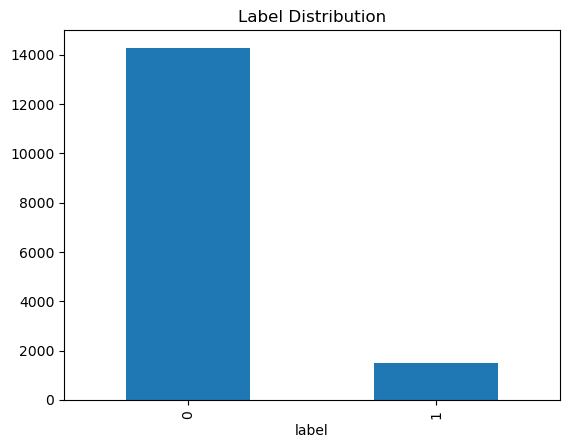

✅ Score calculé.


In [ ]:
df_scores_train_9=aggregation_scoring_Source(residuals_train_9,mappings, df_train, window_size=300)
print("✅ Rank :",residuals_train_9[0])
print("shape=",df_scores_train_9.shape)
df_scores_train_9['label'].value_counts().plot(kind='bar', title='Label Distribution')
plt.show()
print("✅ Score calculé.")

In [ ]:
df=df_scores_train_9
features=['count','bytes','packets','duration']
removed=remove_outliers_iqr(df_scores_train_9,features)
print("✅ Outliers supprimés.")
df_cleaned=pd.concat([removed,df[df['label']==1]],axis=0)

✅ Outliers supprimés.


In [ ]:
def build_and_train_binary_classifier(X_train, y_train, X_test, y_test, learning_rate=0.0001, batch_size=32, epochs=50):
    input_dim = X_train.shape[1]

    # Définition du modèle
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='sigmoid'),
        layers.Dense(80, activation='sigmoid'),
        layers.Dense(80, activation='sigmoid'),
        layers.Dense(32, activation='sigmoid'),
        layers.Dense(32, activation='sigmoid'),
        layers.Dropout(0.3),
        layers.Dense(64, activation='sigmoid'),
        layers.Dropout(0.2),
        layers.Dense(32, activation='sigmoid'),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')

    ])

    # Compilation
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )


    # Entraînement
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        batch_size=batch_size, # Reduced batch size
        epochs=epochs,
        verbose=1
    )

    return model, history

In [ ]:
scale=StandardScaler()
X=df_cleaned.drop(columns=['label','Dst IP','time_windows'])
Y=df_cleaned['label']

In [ ]:
tensor_train.max()

tensor(1.)

Epoch 1/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.3182 - auc_1: 0.5074 - loss: 0.8740 - val_accuracy: 0.8778 - val_auc_1: 0.5000 - val_loss: 0.4580
Epoch 2/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8687 - auc_1: 0.5041 - loss: 0.4474 - val_accuracy: 0.8778 - val_auc_1: 0.5000 - val_loss: 0.3786
Epoch 3/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8761 - auc_1: 0.4821 - loss: 0.3942 - val_accuracy: 0.8778 - val_auc_1: 0.5000 - val_loss: 0.3715
Epoch 4/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8827 - auc_1: 0.4951 - loss: 0.3739 - val_accuracy: 0.8778 - val_auc_1: 0.5000 - val_loss: 0.3714
Epoch 5/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8754 - auc_1: 0.4827 - loss: 0.3884 - val_accuracy: 0.8778 - val_auc_1: 0.5000 - val_loss: 0.3717
Epoch 6/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8751 - auc_1: 0.4893 - loss: 0.3894 - val_accuracy: 0.8778 - val_auc_1: 0.5000 - val_loss: 0.3719
Epoch 7/50
265/2

265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9974 - auc_1: 0.9973 - loss: 0.0161 - val_accuracy: 0.9959 - val_auc_1: 0.9977 - val_loss: 0.0166
Epoch 43/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9976 - auc_1: 0.9973 - loss: 0.0154 - val_accuracy: 0.9972 - val_auc_1: 0.9989 - val_loss: 0.0121
Epoch 44/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9969 - auc_1: 0.9932 - loss: 0.0194 - val_accuracy: 0.9978 - val_auc_1: 0.9989 - val_loss: 0.0105
Epoch 45/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9978 - auc_1: 0.9962 - loss: 0.0146 - val_accuracy: 0.9967 - val_auc_1: 0.9977 - val_loss: 0.0142
Epoch 46/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9976 - auc_1: 0.9965 - loss: 0.0157 - val_accuracy: 0.9967 - val_auc_1: 0.9955 - val_loss: 0.0153
Epoch 47/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9977 - auc_1: 0.9963 - loss: 0.0143 - val_accuracy: 0.9967 - val_auc_1: 0.9944 - val_loss: 0.0152
Epoch 48/50
265/265 ━━

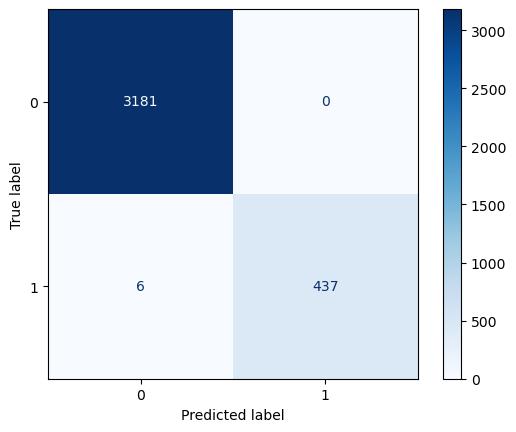

In [ ]:


X1=scale.fit_transform(X)
Y1=df_cleaned['label']
X1_train,X1_test,Y1_train,Y1_test = train_test_split(X1,Y1,test_size=0.3,stratify=Y1)
model,history=build_and_train_binary_classifier(X1_train, Y1_train, X1_test, Y1_test)


# Prédire les probabilités (entre 0 et 1)
y_pred_prob = model.predict(X1_test)
      # Convertir les probabilités en classes binaires (0 ou 1)
y_pred = (y_pred_prob > 0.5).astype(int)
      # Calcul de la matrice de confusion
cm = confusion_matrix(Y1_test, y_pred)
      # Affichage
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')


In [ ]:
torch.cuda.empty_cache()
residuals_test_9 = normal_space_projection(tensor_test, factors_normal_9)
print("✅ Residual calculé.")

kr_product shape: torch.Size([4317144, 1])
slice_t shape: torch.Size([1, 4317144])
[t=0] ✅ Projection & résidu calculés.
Norme relative du résidu : 1.0
slice_t shape: torch.Size([1, 4317144])
[t=1] ✅ Projection & résidu calculés.
Norme relative du résidu : 1.0
slice_t shape: torch.Size([1, 4317144])
[t=2] ✅ Projection & résidu calculés.
Norme relative du résidu : 1.0
slice_t shape: torch.Size([1, 4317144])
[t=3] ✅ Projection & résidu calculés.
Norme relative du résidu : 1.0
slice_t shape: torch.Size([1, 4317144])
[t=4] ✅ Projection & résidu calculés.
Norme relative du résidu : 1.0
slice_t shape: torch.Size([1, 4317144])
[t=5] ✅ Projection & résidu calculés.
Norme relative du résidu : 1.0
slice_t shape: torch.Size([1, 4317144])
[t=6] ✅ Projection & résidu calculés.
Norme relative du résidu : 1.0
slice_t shape: torch.Size([1, 4317144])
[t=7] ✅ Projection & résidu calculés.
Norme relative du résidu : 1.0
slice_t shape: torch.Size([1, 4317144])
[t=8] ✅ Projection & résidu calculés.
Norme r

In [ ]:
mappings_test={'Dst_IP':dst_ip_to_idx,'features_names':dict(enumerate(['count','bytes','packets','duration']))}

In [ ]:
df_scores_test=aggregation_scoring_Source(residuals_test_9,mappings, df_test, window_size=300)
plt.show()
print("✅ Score calculé.")

⏳ Étape 4 : Aggrégation des scores avec labels...
✅ Aggrégation des scores + labels terminée.
✅ Score calculé.


In [ ]:

removed_test=remove_outliers_iqr(df_scores_test,features)
print("✅ Outliers supprimés.")
df_cleaned_test=pd.concat([removed_test,df_scores_test[df_scores_test['label']==1]],axis=0)


✅ Outliers supprimés.


In [ ]:
df_cl

422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


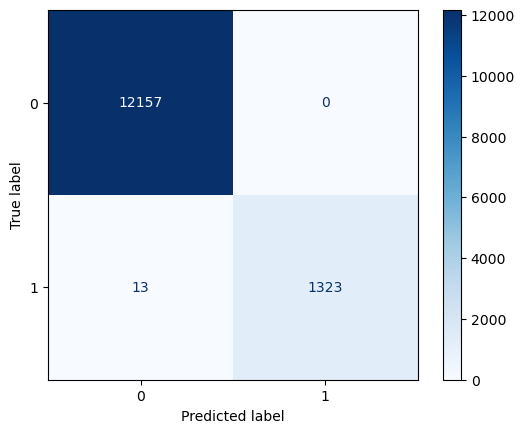

In [ ]:

      X=df_cleaned_test.drop(columns=['label','Dst IP','time_windows'])
      X_scaled=scale.fit_transform(X)
      Y=df_cleaned_test['label']
      y_pred_prob = model.predict(X_scaled)
      # Convertir les probabilités en classes binaires (0 ou 1)
      y_pred = (y_pred_prob > 0.5).astype(int)
      # Calcul de la matrice de confusion
      cm = confusion_matrix(Y, y_pred)
      # Affichage
      disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
      disp.plot(cmap='Blues')
